In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from wordcloud import WordCloud
import itertools
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
import datetime
from gensim import downloader
import tensorflow as tf
from tensorflow import keras

In [2]:
data_train = pd.read_csv('../Data/train.csv',index_col=0)

In [3]:
data_test = pd.read_csv('../Data/test.csv',index_col=0)

In [4]:
data_train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data_test.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
data_train.isna().mean()

keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [7]:
data_train['location'].value_counts().head(20)

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
Everywhere          15
New York, NY        15
California, USA     15
Florida             14
Name: location, dtype: int64

In [8]:
data_train.drop('location',axis=1,inplace=True)
data_test.drop('location',axis=1,inplace=True)

In [9]:
data_train.fillna({'keyword':'None'},inplace=True)
data_test.fillna({'keyword':'None'},inplace=True)

In [10]:
data_train['target'].value_counts()/len(data_train)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [11]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords = ["".join([s for s in w if s not in string.punctuation]) for w in stopwords]

In [12]:
def text_preprocessing(sentence: str):
    sentence = re.sub(r'\n',' ',sentence)
    sentence = ''.join([s.lower() for s in sentence if s not in string.punctuation])
    sentence = [w for w in sentence.split(' ') if w not in stopwords and w != '']
    return [w for w in sentence if w[:4] != 'http']

In [13]:
data_train['text_processed'] = data_train['text'].apply(text_preprocessing)
data_test['text_processed'] = data_test['text'].apply(text_preprocessing)

In [14]:
data_train['len'] = data_train['text_processed'].apply(len)

<AxesSubplot:xlabel='len', ylabel='Probability'>

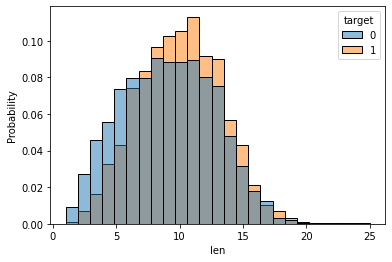

In [15]:
sns.histplot(data=data_train, x='len', bins=25, hue='target', stat='probability',common_norm=False)

In [16]:
pos_words = list(itertools.chain(*data_train[data_train['target']==1]['text_processed'].values))
neg_words = list(itertools.chain(*data_train[data_train['target']==0]['text_processed'].values))

In [17]:
word_cloud = WordCloud(
    background_color='White',
    height=500,
    width=800
)

In [18]:
wc = word_cloud.generate_from_text(' '.join(pos_words))

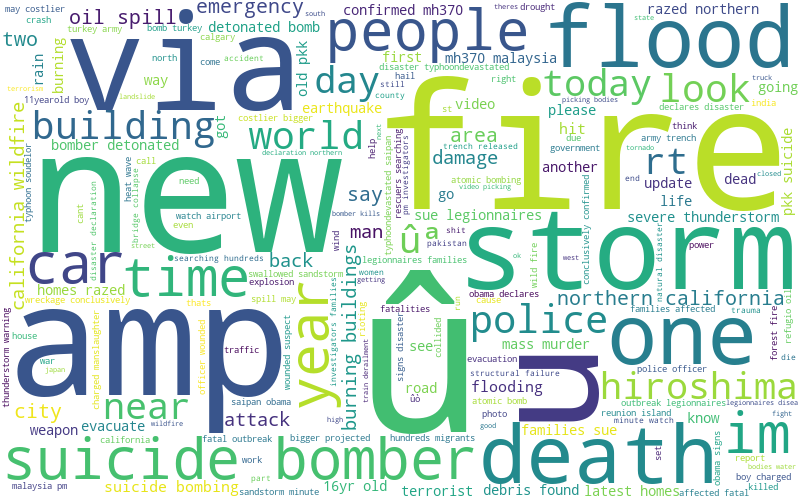

In [19]:
wc.to_image()

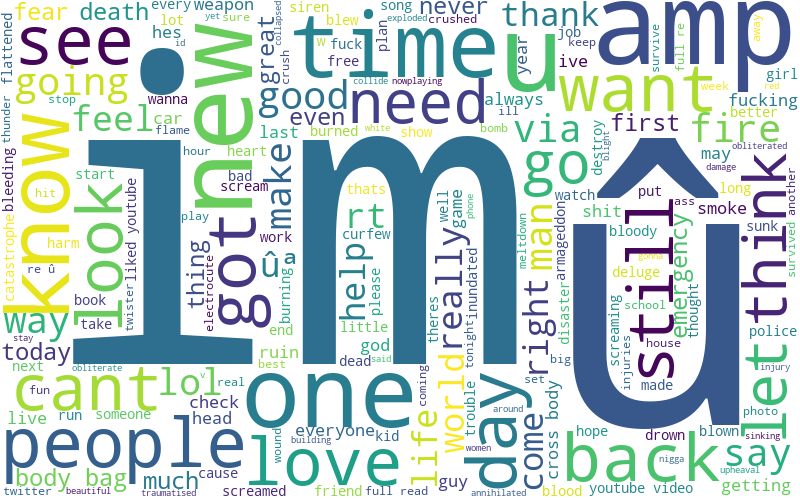

In [20]:
wc = word_cloud.generate_from_text(' '.join(neg_words))
wc.to_image()

In [21]:
X_train, X_cv, y_train, y_cv = train_test_split(
    data_train[['text_processed']],data_train['target'],
    test_size=0.2,
)

In [22]:
vectorizer = TfidfVectorizer()

In [25]:
X_train_tfid = np.array(
    vectorizer.fit_transform(X_train["text_processed"].apply(lambda x: " ".join(x))).todense()
)

In [26]:
X_cv_tfid = np.array(
    vectorizer.transform(X_cv["text_processed"].apply(lambda x: " ".join(x))).todense()
)

In [86]:
def gen_rf_hyperparameters():
    n_estimators = max(int(10 ** (np.random.random() * 1.5 + 1)), 1)
    max_depth = np.random.choice([1, 2, 5, 10, 20])
    min_samples_leaf = np.random.randint(1, 100)
    max_features = np.random.random()
    return {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_leaf": min_samples_leaf,
        "max_features": max_features,
    }

In [87]:
n_cv = 10
score = 0.5
final_params = None
for i in range(n_cv):
    if i % 2 == 0:
        print(
            f"Iteration {i+1} - {n_cv}: CV - {datetime.datetime.today().strftime('%H:%M:%S')}"
        )
    params = gen_rf_hyperparameters()
    model = RandomForestClassifier(**params)
    model.fit(X_train_tfid,y_train)
    probas = model.predict_proba(X_cv_tfid)
    cv_score = roc_auc_score(y_cv,probas[:,1])
    if cv_score > score:
        score = cv_score
        final_params = params
        print(f"Iteration {i} - ROC AUC score :{score}")

Iteration 1 - 10: CV - 14:31:10
Iteration 0 - ROC AUC score :0.6147930987294337
Iteration 1 - ROC AUC score :0.6729089690551631
Iteration 3 - 10: CV - 14:35:06
Iteration 2 - ROC AUC score :0.7056459677674032
Iteration 5 - 10: CV - 14:36:14
Iteration 7 - 10: CV - 14:38:25
Iteration 9 - 10: CV - 14:46:10


In [22]:
word_2_vec = downloader.load('word2vec-google-news-300')
glove = downloader.load('glove-twitter-25')

In [23]:
def vectorize(arr, vectorizer):
    r = None
    for a in arr:
        try:
            if r is None:
                r = np.array([vectorizer[a]])
            else:
                r = np.vstack([r,vectorizer[a]])
        except KeyError:
            pass
    if r is None:
        return np.array([])
    return r

In [24]:
X_train['text_processed_glove'] = X_train['text_processed'].apply(lambda arr: vectorize(arr, glove))
X_train['text_processed_w2v'] = X_train['text_processed'].apply(lambda arr: vectorize(arr, word_2_vec))
X_cv['text_processed_glove'] = X_cv['text_processed'].apply(lambda arr: vectorize(arr, glove))
X_cv['text_processed_w2v'] = X_cv['text_processed'].apply(lambda arr: vectorize(arr, word_2_vec))

In [25]:
glove_len = len(X_train['text_processed_glove'].iloc[0][0])
w2v_len = len(X_train['text_processed_w2v'].iloc[0][0])

In [26]:
def padArr(arr, arr_size, tot_size):
    if len(arr) == 0:
        return np.zeros((tot_size,arr_size))
    for i in range(len(arr),tot_size):
        arr = np.vstack([arr,np.zeros(arr_size)])
    return arr
def padSer(ser, arr_size):
    tot_size = ser.apply(len).max()
    return ser.apply(lambda arr: padArr(arr, arr_size, tot_size))

In [27]:
X_train['text_processed_glove'] = padSer(X_train['text_processed_glove'],glove_len)
X_cv['text_processed_glove'] = padSer(X_cv['text_processed_glove'],glove_len)
X_train['text_processed_w2v'] = padSer(X_train['text_processed_w2v'],w2v_len)
X_cv['text_processed_w2v'] = padSer(X_cv['text_processed_w2v'],w2v_len)

In [28]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Glove SimpleRNN

In [29]:
inputs = keras.layers.Input(shape=(None,glove_len), dtype = tf.float32)
x = keras.layers.Masking(mask_value=0., input_shape=(None, glove_len))(inputs)
x = keras.layers.SimpleRNN(10)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_gs = keras.Model(inputs, outputs)

Metal device set to: Apple M1 Max


2022-07-28 17:38:02.969603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-28 17:38:02.969738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [30]:
model_gs.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
)

In [31]:
model_gs.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 25)]        0         
                                                                 
 masking (Masking)           (None, None, 25)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                360       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


In [32]:
fit_hist_gs = model_gs.fit(
    x=np.stack(X_train['text_processed_glove']),
    y=y_train,
    validation_data=(np.stack(X_cv['text_processed_glove']), y_cv),
    epochs = 100,
    callbacks=[early_stopping],
    verbose=0,
)

2022-07-28 17:38:03.100399: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-28 17:38:03.557796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 17:38:55.296222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


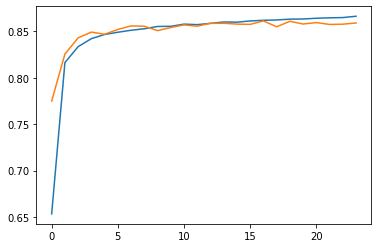

In [45]:
plt.plot(fit_hist_gs.history['auc'])
plt.plot(fit_hist_gs.history['val_auc'])

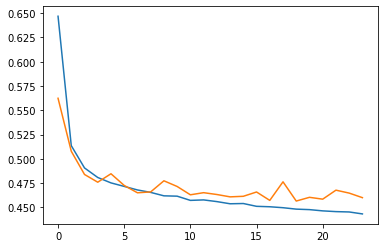

In [46]:
plt.plot(fit_hist_gs.history['loss'])
plt.plot(fit_hist_gs.history['val_loss'])

### W2V SimpleRNN

In [33]:
inputs = keras.layers.Input(shape=(None,w2v_len), dtype = tf.float32)
x = keras.layers.Masking(mask_value=0., input_shape=(None, w2v_len))(inputs)
x = keras.layers.SimpleRNN(10)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_ws = keras.Model(inputs, outputs)

In [34]:
model_ws.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
)

In [35]:
model_ws.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 300)]       0         
                                                                 
 masking_1 (Masking)         (None, None, 300)         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                3110      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


In [36]:
fit_hist_ws = model_ws.fit(
    x=np.stack(X_train['text_processed_w2v']),
    y=y_train,
    validation_data=(np.stack(X_cv['text_processed_w2v']), y_cv),
    epochs = 100,
    callbacks=[early_stopping],
    verbose=0,
)

2022-07-28 17:58:31.373213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 17:59:14.598809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


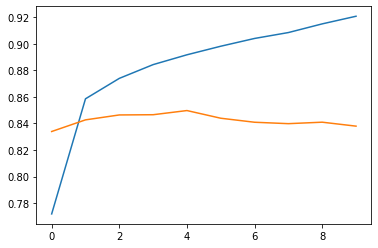

In [50]:
plt.plot(fit_hist_ws.history['auc_1'])
plt.plot(fit_hist_ws.history['val_auc_1'])

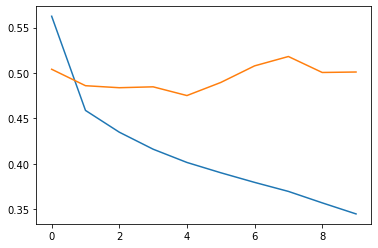

In [51]:
plt.plot(fit_hist_ws.history['loss'])
plt.plot(fit_hist_ws.history['val_loss'])

### Glove LSTM

In [37]:
inputs = keras.layers.Input(shape=(None,glove_len), dtype = tf.float32)
x = keras.layers.Masking(mask_value=0., input_shape=(None, glove_len))(inputs)
x = keras.layers.LSTM(10)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_gl = keras.Model(inputs, outputs)

In [38]:
model_gl.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
)

In [39]:
model_gl.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 25)]        0         
                                                                 
 masking_2 (Masking)         (None, None, 25)          0         
                                                                 
 lstm (LSTM)                 (None, 10)                1440      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,451
Trainable params: 1,451
Non-trainable params: 0
_________________________________________________________________


In [40]:
fit_hist_gl = model_gl.fit(
    x=np.stack(X_train['text_processed_glove']),
    y=y_train,
    validation_data=(np.stack(X_cv['text_processed_glove']), y_cv),
    epochs = 100,
    callbacks=[early_stopping],
    verbose=0,
)

2022-07-28 18:06:01.736172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 18:06:02.118740: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2022-07-28 18:06:02.122847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 18:06:02.396299: I tensorflow/co

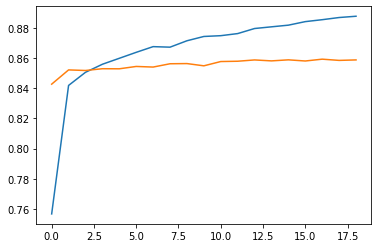

In [52]:
plt.plot(fit_hist_gl.history['auc_2'])
plt.plot(fit_hist_gl.history['val_auc_2'])

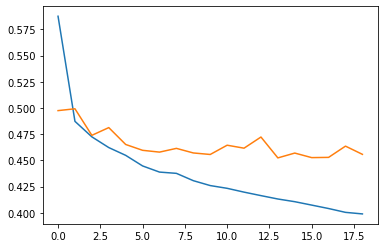

In [53]:
plt.plot(fit_hist_gl.history['loss'])
plt.plot(fit_hist_gl.history['val_loss'])

### W2V LSTM

In [41]:
inputs = keras.layers.Input(shape=(None,w2v_len), dtype = tf.float32)
x = keras.layers.Masking(mask_value=0., input_shape=(None, w2v_len))(inputs)
x = keras.layers.LSTM(10)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_wl = keras.Model(inputs, outputs)

In [42]:
model_wl.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
)

In [43]:
model_wl.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 300)]       0         
                                                                 
 masking_3 (Masking)         (None, None, 300)         0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                12440     
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________


In [44]:
fit_hist_wl = model_wl.fit(
    x=np.stack(X_train['text_processed_w2v']),
    y=y_train,
    validation_data=(np.stack(X_cv['text_processed_w2v']), y_cv),
    epochs = 100,
    callbacks=[early_stopping],
    verbose=0,
)

2022-07-28 18:07:52.827307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 18:07:53.214460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 18:07:53.471218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 18:08:00.188535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 18:08:00.416736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


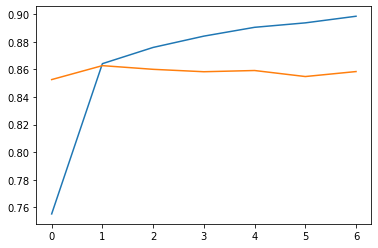

In [54]:
plt.plot(fit_hist_wl.history['auc_3'])
plt.plot(fit_hist_wl.history['val_auc_3'])

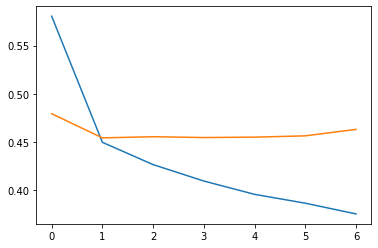

In [55]:
plt.plot(fit_hist_wl.history['loss'])
plt.plot(fit_hist_wl.history['val_loss'])